In [1]:
import os
from pathlib import Path

import sys
sys.path.append('..')


from babilong.metrics import compare_answers, TASK_LABELS

import seaborn as sns
import matplotlib
import matplotlib.pylab as plt
from matplotlib.colors import LinearSegmentedColormap

import pandas as pd
import numpy as np

## Visualize evaluation results

In [2]:
results_folder =  Path('../babilong_evals')
model_names = []
for path in results_folder.glob('*/*'):
    model_names += [f'{path.parent.name}/{path.name}']
print(model_names)

['lmsys/longchat-7b-v1.5-32k', 'mistralai/Mistral-7B-Instruct-v0.2', 'mistralai/Mixtral-8x7B-Instruct-v0.1', 'mistralai/Mixtral-8x22B-Instruct-v0.1', 'mistralai/Mistral-7B-Instruct-v0.3', 'CohereForAI/c4ai-command-r-v01', 'NousResearch/Yarn-Mistral-7b-128k', 'namespace-Pt/activation-beacon-llama2-7b-chat', 'namespace-Pt/activation-beacon-mistral-7b', 'Yukang/LongAlpaca-13B', 'togethercomputer/LLaMA-2-7B-32K', 'togethercomputer/Llama-2-7B-32K-instruct', 'THUDM/chatglm3-6b-128k', 'THUDM/glm-4-9b-chat-1m', 'openai/gpt-3.5-turbo-1106', 'openai/gpt-3.5-turbo-1106-qa1-1k', 'openai/gpt-3.5-turbo-1106-qa1-100', 'openai/gpt-4-0125-preview', 'openai/gpt-4o-mini-2024-07-18', 'openai/o1-preview-2024-09-12', 'microsoft/Phi-3-mini-128k-instruct', 'microsoft/Phi-3.5-MoE-instruct', 'microsoft/Phi-3.5-mini-instruct', 'meta-llama/Meta-Llama-3.1-8B-Instruct', 'meta-llama/Meta-Llama-3.1-8B-Instruct_vllm', 'meta-llama/Meta-Llama-3.1-70B-Instruct', 'meta-llama/Llama-3.2-1B-Instruct', 'meta-llama/Llama-3.2-3

In [3]:
model_names = ['openai/gpt-4-0125-preview', 'openai/gpt-4o-mini-2024-07-18',
               'meta-llama/Llama-3.2-3B-Instruct', 'meta-llama/Meta-Llama-3.1-8B-Instruct', 'meta-llama/Meta-Llama-3.1-70B-Instruct',
               'Qwen/Qwen2.5-7B-Instruct', 'Qwen/Qwen2.5-72B-Instruct',
               'google/gemma-2-9b-it', 'google/gemma-3-4b-it', 'google/gemma-3-12b-it',
               ]
tasks = ['qa1', 'qa2', 'qa3', 'qa4', 'qa5']
lengths = ['0k', '1k', '2k', '4k', '8k', '16k', '32k', '64k', '128k']#, '512k', '1M']

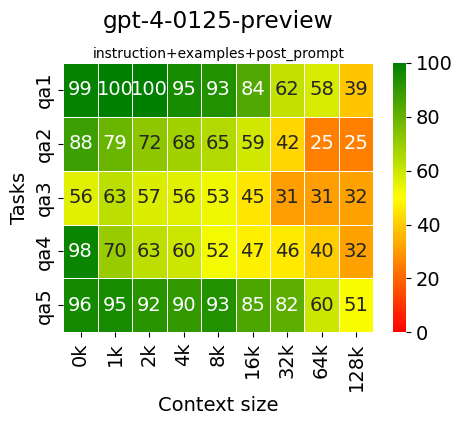

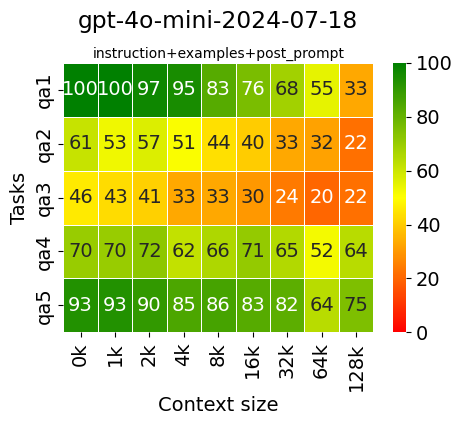

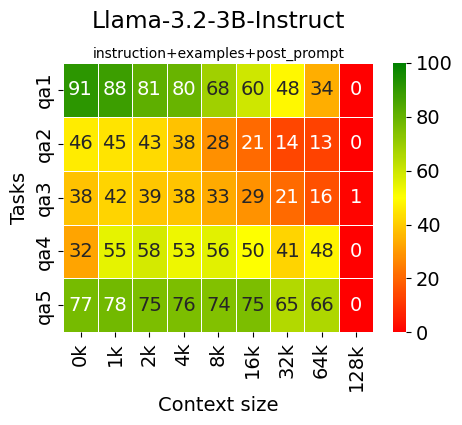

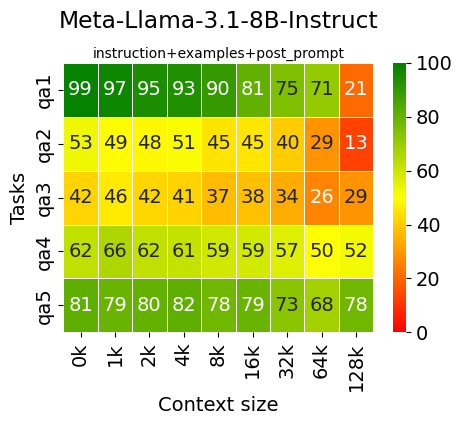

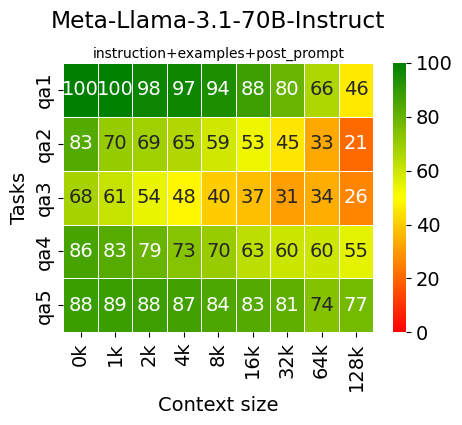

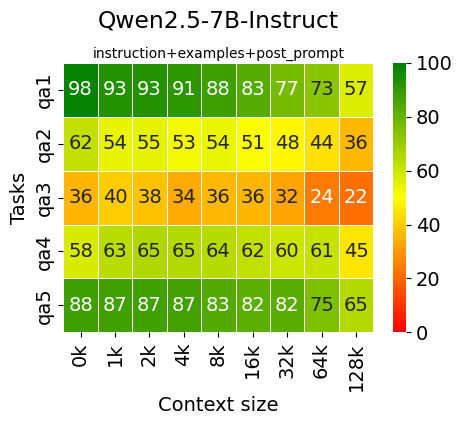

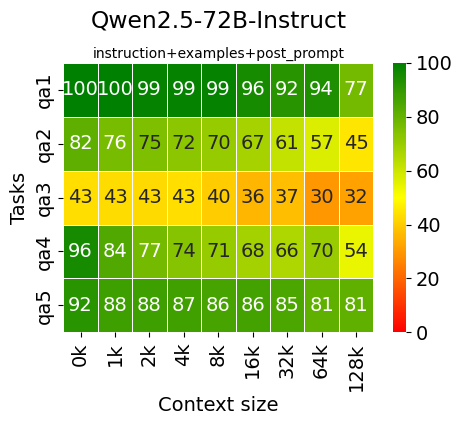

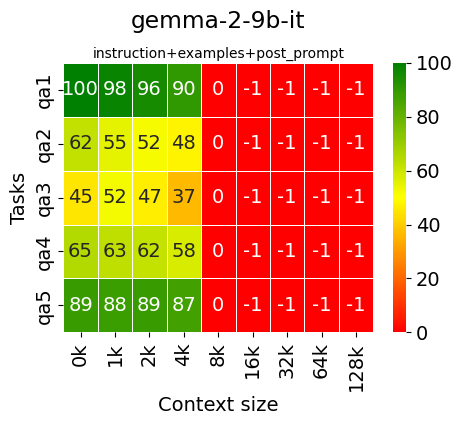

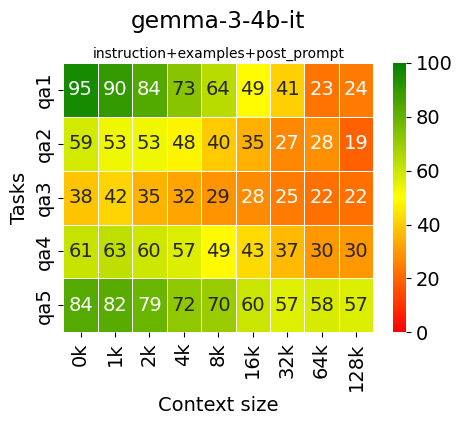

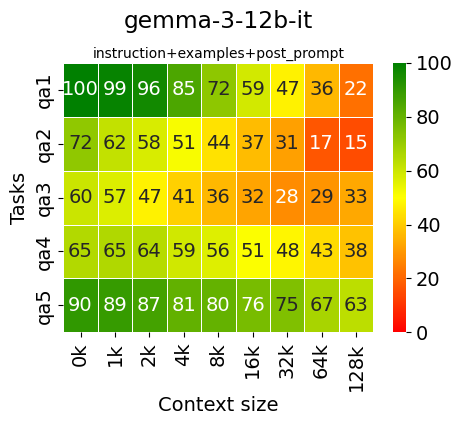

In [4]:
def parse_run_cfg(cfg_str):
    parts = cfg_str.split('_')
    result = {}
    key_parts = []
    for p in parts:
        if p in ("yes", "no"):
            key = "_".join(key_parts)
            result[key] = (p == "yes")
            key_parts = []
        else:
            key_parts.append(p)
    return result

results = {}

for model_name in model_names:
    model_results_folder = results_folder / model_name
    run_configurations = set()
    for fn in model_results_folder.glob('*.csv'):
        run_configurations.add('_'.join(fn.stem.split('_')[2:]))

    if len(run_configurations) > 0:
        results[model_name] = {}

    for run_cfg in run_configurations:
        accuracy = np.ones((len(tasks), len(lengths))) * -1
        for j, task in enumerate(tasks):
            for i, ctx_length in enumerate(lengths):
                fname = model_results_folder / f'{task}_{ctx_length}_{run_cfg}'
                results_fname = fname.with_suffix('.csv')
                cfg_fname = fname.with_suffix('.json')
                if not results_fname.exists():
                    continue

                df = pd.read_csv(results_fname)
                    
                if df['output'].dtype != object:
                    df['output'] = df['output'].astype(str)
                df['output'] = df['output'].fillna('')


                df['correct'] = df.apply(lambda row: compare_answers(target=row['target'], output=row['output'],
                                                                    question=row['question'],
                                                                    task_labels=TASK_LABELS[task]), axis=1)
                score = df['correct'].sum()
                accuracy[j, i] = 100 * score / len(df) if len(df) > 0 else 0
                results[model_name][run_cfg] = accuracy

    model_results = results[model_name]
    # Set large font sizes for better visibility in the PDF
    matplotlib.rc('font', size=14)
    # Create a colormap for the heatmap
    cmap = LinearSegmentedColormap.from_list('ryg', ["red", "yellow", "green"], N=256)

    # Create the heatmap
    fig, axes = plt.subplots(1, len(model_results), figsize=(5 * len(model_results), 3.5))
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])
    for i, run_cfg in enumerate(sorted(model_results.keys())):
        sns.heatmap(model_results[run_cfg], cmap=cmap, vmin=0, vmax=100, annot=True, fmt=".0f",
                    linewidths=.5, xticklabels=lengths, yticklabels=tasks, ax=axes[i])
        
        cfg_string = ''
        for k, v in parse_run_cfg(run_cfg).items():
            if v and k not in ['chat_template', 'system_prompt']:
                cfg_string += f'{k}+'
        cfg_string = cfg_string[:-1]

        # Set the main title.
        axes[i].set_title(f"{model_name.split('/')[-1]}\n")

        # Add a second line with a smaller font, positioned above the axis.
        axes[i].text(0.5, 1.02, cfg_string, transform=axes[i].transAxes, ha='center', fontsize=10)
        axes[i].set_xlabel('Context size')
        axes[i].set_ylabel('Tasks')
    # Save the figure to a PDF
    # plt.savefig('all_tasks_performance.pdf', bbox_inches='tight')
    plt.show()

### Visualize the results for copy-paste format

In [5]:
results.keys()

dict_keys(['openai/gpt-4-0125-preview', 'openai/gpt-4o-mini-2024-07-18', 'meta-llama/Llama-3.2-3B-Instruct', 'meta-llama/Meta-Llama-3.1-8B-Instruct', 'meta-llama/Meta-Llama-3.1-70B-Instruct', 'Qwen/Qwen2.5-7B-Instruct', 'Qwen/Qwen2.5-72B-Instruct', 'google/gemma-2-9b-it', 'google/gemma-3-4b-it', 'google/gemma-3-12b-it'])

In [6]:
pd.set_option('display.max_colwidth', None)

In [7]:
mn = 'meta-llama/Meta-Llama-3.1-70B-Instruct'

cfg = 'instruction_yes_examples_yes_post_prompt_yes_chat_template_yes'

tab = results[mn][cfg]
tab = pd.DataFrame(tab, index=tasks, columns=lengths[:tab.shape[1]])

tab['len_avg'] = tab.mean(axis=1)
tab.loc['avg'] = tab.mean(axis=0)
tab.iloc[:,:-1].round().astype(int)

,0k,1k,2k,4k,8k,16k,32k,64k,128k
qa1,100,100,98,97,94,88,80,66,46
qa2,83,70,69,65,59,53,45,33,21
qa3,68,61,54,48,40,37,31,34,26
qa4,86,83,79,73,70,63,60,60,55
qa5,88,89,88,87,84,83,81,74,77
avg,85,81,78,74,70,65,59,53,45


In [8]:
mn = 'google/gemma-3-4b-it'

# Create a DataFrame to store best results for each task
best_tab = None
best_avgs = {}
best_cfgs = {}  # Store best config for each task

# Go through each configuration
for cfg in results[mn].keys():
    tab = results[mn][cfg]
    tab = pd.DataFrame(tab, index=tasks, columns=lengths[:tab.shape[1]])
    tab['len_avg'] = tab.mean(axis=1)
    print(f'{mn}\n{cfg}')
    display(tab.iloc[:,:-1].round().astype(int))
    
    # For each task, check if this config gives better results
    for task in tasks:
        curr_avg = tab.loc[task, 'len_avg']
        if task not in best_avgs or curr_avg > best_avgs[task]:
            if best_tab is None:
                best_tab = tab.copy()
                best_tab['best_cfg'] = ''  # Add column for best configs
            best_tab.loc[task] = tab.loc[task]
            best_tab.loc[task, 'best_cfg'] = cfg
            best_avgs[task] = curr_avg
            best_cfgs[task] = cfg

# Add average row
best_tab.loc['avg'] = best_tab.iloc[:,:-2].mean(axis=0)  # Don't average the best_cfg column
best_tab.loc['avg', 'best_cfg'] = 'N/A'  # Mark as not applicable for average row

# Display rounded results without len_avg column, but keep best_cfg
display_cols = list(best_tab.columns[:-2]) + ['best_cfg']  # All cols except len_avg

print(f'{mn}\nbest setups:')
display(best_tab[display_cols].round().astype({col: int for col in best_tab.columns[:-2]}))
display(best_tab[display_cols[:-1]].round().astype({col: int for col in best_tab.columns[:-2]}))

google/gemma-3-4b-it
instruction_yes_examples_yes_post_prompt_yes_chat_template_yes_system_prompt_yes


,0k,1k,2k,4k,8k,16k,32k,64k,128k
qa1,95,90,84,73,64,49,41,23,24
qa2,59,53,53,48,40,35,27,28,19
qa3,38,42,35,32,29,28,25,22,22
qa4,61,63,60,57,49,43,37,30,30
qa5,84,82,79,72,70,60,57,58,57


google/gemma-3-4b-it
best setups:


,0k,1k,2k,4k,8k,16k,32k,64k,128k,best_cfg
qa1,95,90,84,73,64,49,41,23,24,instruction_yes_examples_yes_post_prompt_yes_chat_template_yes_system_prompt_yes
qa2,59,53,53,48,40,35,27,28,19,instruction_yes_examples_yes_post_prompt_yes_chat_template_yes_system_prompt_yes
qa3,38,42,35,32,29,28,25,22,22,instruction_yes_examples_yes_post_prompt_yes_chat_template_yes_system_prompt_yes
qa4,61,63,60,57,49,43,37,30,30,instruction_yes_examples_yes_post_prompt_yes_chat_template_yes_system_prompt_yes
qa5,84,82,79,72,70,60,57,58,57,instruction_yes_examples_yes_post_prompt_yes_chat_template_yes_system_prompt_yes
avg,67,66,62,56,50,43,37,32,30,N/A


,0k,1k,2k,4k,8k,16k,32k,64k,128k
qa1,95,90,84,73,64,49,41,23,24
qa2,59,53,53,48,40,35,27,28,19
qa3,38,42,35,32,29,28,25,22,22
qa4,61,63,60,57,49,43,37,30,30
qa5,84,82,79,72,70,60,57,58,57
avg,67,66,62,56,50,43,37,32,30
